#Introduction


**1.   The Task:**

  Trying to implement the LSTM (Long Short-Term Memery) artificial neural network (ANN), a variation of RNN (Recurrent Neural Network) to predict a year long (2021) closing price of Bitcoin (a crypto-currency).

**2.   Why BTC?**

  Beside the its growing popularity, Bitoin fast & complex fluctuations made its forcasting task appealing.

**3.   Why LSTM model?**

  LSTM model offers the folowing benefits:
  - The model is well suited for sequential data (text, speech or even time series), due to the combination of memory & forget mechanisms inside its  hidden cells.

  - Unlike classic RNN, LSTM came as a solution to the exploding & vanishing gradient.
  
A great explanation of LSTM working mechanism is well presented [here](https:////towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) and [here](https://olah.github.io/posts/2015-08-Understanding-LSTMs/).



# Loading necessary packages

In [ ]:
import numpy as np 
import pandas as pd
pd.set_option('display.expand_frame_repr', False) # To view all columns

!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf #Yahoo! finance

from matplotlib import pyplot as plt

from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

The choice for the swish activation function is originated from [this discussion](https://stackoverflow.com/questions/58761233/what-is-the-best-activation-function-to-use-for-time-series-prediction), a full explanation is provided in [this post.](https://medium.com/@neuralnets/swish-activation-function-by-google-53e1ea86f820)

In [ ]:
# Custom activation function
# Known as "swish"
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation

def custom_activation(x, beta = 1):
        return (K.sigmoid(beta * x) * x)

get_custom_objects().update({'swish': Activation(custom_activation)})

#EDA

## Read in the dataset to a dataframe 
Using the Yahoo! finance (yfinance) python package to load the daily trading data of Bitcoin between 2014 to 2021.

In [ ]:
df = yf.download('BTC-USD', 
                 end= '2021-12-31',
                 progress=True)
print(df.head(),
      "\n",
      100 * "-",
      "\n",
      'Data shape: ', df.shape)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close    Volume
Date                                                                            
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015  21056800
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002  34483200
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990  37919700
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992  36863600
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014  26580100 
 ---------------------------------------------------------------------------------------------------- 
 Data shape:  (2663, 6)


## Preliminary analysis of the Data
- Checking for missing values:

In [ ]:
# Checking for NaN values
print('Any missing values ?')

if df.isnull().values.any():
  print('There is %d missing values in Data', df.isnull().sum())
else:
  print('There is no missing values in Data')

Any missing values ?
There is no missing values in Data


- Summary of descriptive statistics:

In [ ]:
# Descriptive stats summery
print('Descriptive statistics\n')
print(df.describe().T)
print("\n")

Descriptive statistics

            count          mean           std           min           25%           50%           75%           max
Open       2663.0  1.074481e+04  1.570680e+04  1.768970e+02  5.944675e+02  6.164280e+03  1.020291e+04  6.754973e+04
High       2663.0  1.103955e+04  1.614043e+04  2.117310e+02  6.015945e+02  6.308510e+03  1.040696e+04  6.878962e+04
Low        2663.0  1.042279e+04  1.521261e+04  1.715100e+02  5.871495e+02  5.920086e+03  9.922276e+03  6.638206e+04
Close      2663.0  1.076023e+04  1.571616e+04  1.781030e+02  5.962070e+02  6.173230e+03  1.021774e+04  6.756683e+04
Adj Close  2663.0  1.076023e+04  1.571616e+04  1.781030e+02  5.962070e+02  6.173230e+03  1.021774e+04  6.756683e+04
Volume     2663.0  1.447025e+10  2.007104e+10  5.914570e+06  7.753150e+07  4.935290e+09  2.432886e+10  3.509679e+11




## Overview plot of the target data (Daily closing price of Bitcoin)

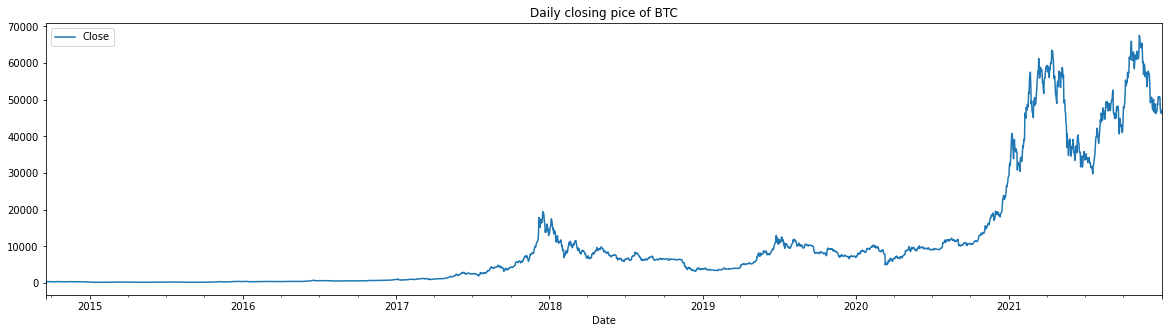

In [ ]:
# Ploting the Data
df.plot(y ='Close',
        figsize = (20, 5),
        title = 'Daily closing pice of BTC',
        legend = True)

The plot clearly shows two main carateristics:
- the exploding closing-price of Bitcoin in late couple of years.
- The hight annualized [volatility](https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/) as shown in the folowing plot:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faa8956fd10>,
      dtype=object)

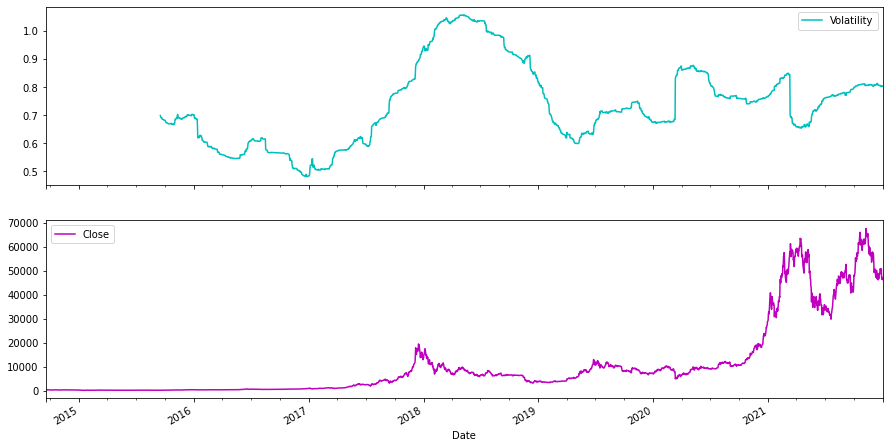

In [ ]:
# Compute the logarithmic returns using the Closing price 
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))

# Compute Volatility using the pandas rolling standard deviation function
df['Volatility'] = df['Log_Ret'].rolling(window=365).std() * 365 ** .5

# Plot the Closing Price series and the Volatility
df[['Volatility', 'Close']].plot(subplots= 2, color= 'cmap' ,figsize=(15, 8))

Where the Realized Volatility: Close-Close is equal to:


In [ ]:
print('Annualized Volatility = %.2f' %np.sum(df['Volatility']), '%')

Annualized Volatility = 1693.75 %


# Modeling


## Choosing the Closing price of BTC (Bitcoin ticker) as target value.

In [ ]:
### encode the date 
#df['date'] = pd.to_datetime(df['Date']).dt.date

Close_Price = df['Close']

print(Close_Price.head(),
      '\n',
      100 * '-',
      '\n',
      'Shape of Data: ',Close_Price.shape)

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64 
 ---------------------------------------------------------------------------------------------------- 
 Shape of Data:  (2663,)



## Training & testing Data splits:

The data is split into:

- 2298 data points (from 09-17-2014 to 12-31-2020) as training and validation set.
  - *LSTM model will procede internally to choose the validation data by setting the validation_split parameter*.
- 365 data points (year 2021) as testing set.

[Here](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) is a primer about the data spliting.

In [ ]:
### split dataset into train and test sets 
prediction_days = 365 #To predict the Closing price of 2021
df_train = Close_Price[:len(Close_Price) - prediction_days]
df_test = Close_Price[len(Close_Price) - prediction_days:]

print(df_train.head(),"\n")
print(df_train.shape,"\n")
print(df_test.head(),"\n")
print(df_test.shape,"\n")

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64 

(2298,) 

Date
2021-01-01    29374.152344
2021-01-02    32127.267578
2021-01-03    32782.023438
2021-01-04    31971.914062
2021-01-05    33992.429688
Name: Close, dtype: float64 

(365,) 



## Why is it important to reshape input data of LSTM model?

The LSTM require the input data to be shaped as 3D array, which correspond to (NumberOfExamples, TimeSteps, FeaturesPerStep). 

For more details, check [this tutorial](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras) and [this discussion](https://stackoverflow.com/questions/46165464/reshape-keras-input-for-lstm)

In [ ]:
# Data preprocessing
## 1st step reshaping data
training_set = df_train.values 
print("Training set before reshaping")
print(training_set.shape,"\n")

training_set = np.reshape(training_set, (len(training_set), 1))
print("Training set after reshaping")
print(training_set.shape,"\n") ## MinMaxScaler expecte <= 2D

Training set before reshaping
(2298,) 

Training set after reshaping
(2298, 1) 



## The use of scaling data for LSTM model

Mathematically, it is better for the model optimizer to get scaled (limited range, ideally from 0 to 1) input data.

Scalled Input data are easily suited for gradient descent search for the optimal solution.

More detailed explanation is found in this [lecture](https://www.coursera.org/lecture/machine-learning/gradient-descent-in-practice-i-feature-scaling-xx3Da).

In [ ]:
#Scaling training data
sc = MinMaxScaler() 
training_set = sc.fit_transform(training_set) 

X_train = training_set[0 : len(training_set) -1]
print("Define X_train:")
print(X_train.shape, "\n")

y_train = training_set[1 : len(training_set)]
print("Define y_train:")
print(y_train.shape, "\n")

# 2nd Step reshaping
X_train = np.reshape(X_train, (len(X_train),1, 1)) #Now we have our 3D input array.                      
print("X_train reshaped:")
print(X_train.shape, "\n")

Define X_train:
(2297, 1) 

Define y_train:
(2297, 1) 

X_train reshaped:
(2297, 1, 1) 



##Model parameters

1.   Error metric:
  - Choosing the simplest and classical form of error metric, mean squared error as explained in this [post](https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27)

1.   Activation function:
  - The choise of 'Swish' activation function is found and recommanded in this [discussion](https://stackoverflow.com/questions/58761233/what-is-the-best-activation-function-to-use-for-time-series-prediction) as suitable for time series forcasting.

2.   Learning rate:
  - Left as default




In [ ]:
#Model definition

model = Sequential() 
model.add(LSTM(units = 128,
               activation = 'swish', 
               input_shape =(None, 1)))   
model.add(Dense(units =1))

#Model compilation
model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam(),
              metrics= [tf.metrics.MeanAbsoluteError()])

In [ ]:
#Model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model on the training set 
model.fit(X_train, y_train, validation_split= .10, batch_size = 50, epochs = 100)

Epoch 1/100
42/42 [==============================] - 2s 10ms/step - loss: 0.0275 - mean_absolute_error: 0.1200 - val_loss: 0.1343 - val_mean_absolute_error: 0.3362
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0162 - mean_absolute_error: 0.1087 - val_loss: 0.0825 - val_mean_absolute_error: 0.2543
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0133 - mean_absolute_error: 0.1021 - val_loss: 0.0677 - val_mean_absolute_error: 0.2309
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0104 - mean_absolute_error: 0.0906 - val_loss: 0.0460 - val_mean_absolute_error: 0.1905
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0739 - val_loss: 0.0251 - val_mean_absolute_error: 0.1425
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0035 - mean_absolute_error: 0.0520 - val_loss: 0.0083 - val_mean_absolute_error: 0.0840
Epoch 7/100
42/42 [==

#Results

##Display Deep Learning Model Training History in Keras
A first glimse into model behaviour.

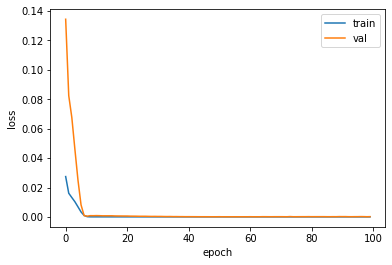

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

While the training and validation loss are converging, the plot shows no sign of overfitting.

## Testing the model

Prediction for the entire 2021

In [ ]:
### create predictions on the test set 
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1)) 
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs) 
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [ ]:
### get evaluation of the model predictions 
model_evaluation = model.evaluate(inputs, predicted_BTC_price) 

print("Model evaluation is: ", model_evaluation)  
print('')

12/12 [==============================] - 0s 2ms/step - loss: 2453374976.0000 - mean_absolute_error: 48326.6953
Model evaluation is:  [2453374976.0, 48326.6953125]



Visualize the results:



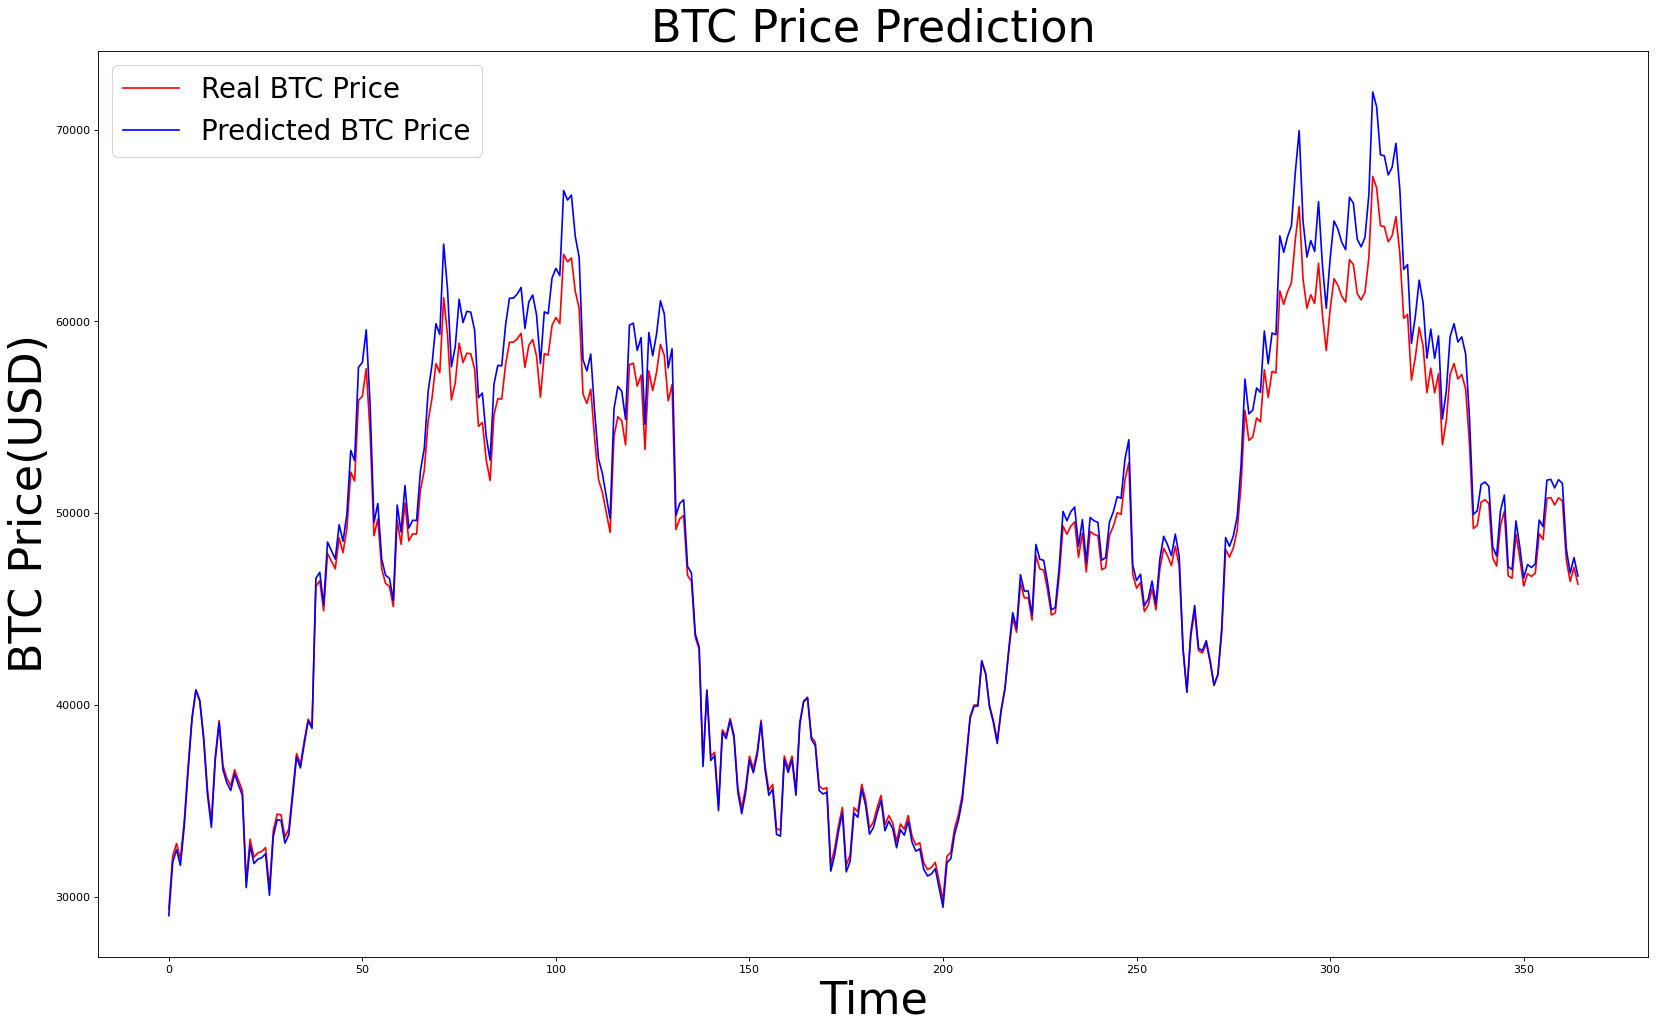

In [ ]:
### visualize the results 
print("Visualize the results:") 
print('')

### plot the actual and predicted prices 
plt.figure(figsize =(25, 15), dpi =80, facecolor ='w', edgecolor ='k')
ax = plt.gca()
plt.plot(test_set, color = 'red', label = "Real BTC Price") 
plt.plot(predicted_BTC_price, color = 'blue', label = "Predicted BTC Price") 
plt.title("BTC Price Prediction", fontsize = 40)

### reindex the 'df_test' dataframe 
#df_test = df_test.reset_index(drop=True) 
#x = df_test.index

### set labels
#labels = df.index #Problem of overlapping dates

### set xticks 
plt.xticks(#x, ##Problem of overlapping dates
           #labels= labels, 
           rotation=0)

### set fontsize for 'x' and 'y' ticks 
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(10)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(10)
    
### set plot labels 
plt.xlabel('Time', fontsize = 40)
plt.ylabel('BTC Price(USD)', fontsize = 40)

### set plot legend
plt.legend(loc = 2, prop = {'size' : 25})  

### show the plot
plt.show()

Still having trouble fixing the dates overlap in Matplotlib 😜

## Evaluate performance

One of the most intuitive way to evaluate forcasting performance is the *mean absolute percentage error*, which mesure the [accuracy as a percentage of the error](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/time-series/how-to/trend-analysis/interpret-the-results/all-statistics-and-graphs/#mape).

The task is easily carried out in SciKitLearn python libray as following:

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(df_test, predicted_BTC_price) * 100
print('MAPE = %.2f' %mape, '%')

MAPE = 1.92 %


Which is a [very good](https://stephenallwright.com/good-mape-score/) perfomance.

#Conclusion

Getting the forcast of a year long of BTC with a 1.92% MAPE is fun, but the real feat is:
 - Trying more granular forcast, by hours, minutes or even seconds,
 - Including more controle data series.
 - Making a forcasting script with real-time web-scrapping and prediction.

 Hope you're having fun through out this notebook, will be happy to [hear](mailto:mohamed.mzaouali@gmail.com) from you soon. 




#References:

Here is a list of articles, ipython notebook and posts whose help was indispensable for the completion of the present task:

[1](https://colab.research.google.com/github/huseinzol05/Stock-Prediction-Models/blob/master/misc/bitcoin-analysis-lstm.ipynb#scrollTo=spurJCyVTxiO)

[2](https://colab.research.google.com/github/paulgureghian/Google_Colab_Notebooks/blob/master/Bitcoin_Price_Prediction.ipynb#scrollTo=_yUIW35p49jW)

[3](https://github.com/nicholasjhana/short-term-energy-demand-forecasting)

[4](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)

[5](https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27)

[6](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb)

[7](https://pypi.org/project/yfinance/)

[8](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras%5D)

[9](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21%5D)

[10](https://colah.github.io/posts/2015-08-Understanding-LSTMs/%5D)

[11](https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27)

[12](https://stackoverflow.com/questions/58761233/what-is-the-best-activation-function-to-use-for-time-series-prediction)

[13](https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/)

[14](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)